# BAX 452: Assignment 4 Solutions

In [121]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.genmod as gm
import statsmodels.formula.api as smf
import statsmodels as stat
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

1. Using hotel_cancellation.csv, write code to estimate the treatment effects if a ‘different room is assigned’ as the treatment indicator and interpret its effect on the room being ‘canceled’. Use all the other columns as the covariates. Write your observations for the results.

In [122]:
# Load the hotel cancellation dataset
data = pd.read_csv('hotel_cancellation.csv').drop(columns = ['Unnamed: 0'])
data['is_canceled'] = data.is_canceled.replace({True: 1, False: 0})
data['different_room_assigned'] = data.different_room_assigned.replace({True: 1, False: 0})

X_data = data.drop(['is_canceled'], axis = 1)
y_data = data['is_canceled']

# add a constant term to the covariates
X_data = sm.add_constant(X_data)

# fit a logistic regression model with treatment and covariates
model = sm.Logit(y_data, X_data).fit()

# print the treatment effect estimate and its standard error
print('Treatment effect estimates:')
print(model.params)
print('Standard error:', model.bse['different_room_assigned'])

Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 12
Treatment effect estimates:
const                        356.546399
lead_time                      0.005337
arrival_date_year             -0.177160
arrival_date_week_number      -0.009319
arrival_date_day_of_month     -0.000601
days_in_waiting_list           0.000766
different_room_assigned       -2.549950
dtype: float64
Standard error: 0.04388716333246911


In [123]:
print('odds ratio', np.e**model.params['different_room_assigned'])

odds ratio 0.07808554406677612


In [66]:
print('Different room NOT assigned', 'Not canceled', len((data.loc[(data['different_room_assigned'] == 0) & (data['is_canceled'] == 0)])))
print('Different room NOT assigned', 'Canceled', len((data.loc[(data['different_room_assigned'] == 0) & (data['is_canceled'] == 1)])))
print('Different room assigned', 'Not canceled', len((data.loc[(data['different_room_assigned'] == 1) & (data['is_canceled'] == 0)])))
print('Different room assigned', 'Canceled', len((data.loc[(data['different_room_assigned'] == 1) & (data['is_canceled'] == 1)])))

Different room NOT assigned Not canceled 52086
Different room NOT assigned Canceled 39587
Different room assigned Not canceled 10647
Different room assigned Canceled 574


While we are not controlling for the impact of the covariates on the treatment effect in this problem, it gives us a ballpark value to expect. Recall that to get from the coefficient of the treatment variable to the odds ratio, we need to exponentiate the coefficient. Specifically, the exponentiated coefficient (also known as the odds ratio) is defined as the ratio of the odds of the outcome occurring in the treatment group to the odds of the outcome occurring in the control group.

We find the odds ratio in this problem to be ~0.078. Because the odds ratio in this case is less than 1, it indicates that the treatment is associated with a lower odds of the outcome occurring.

Interestingly, and almost counterintuitively, this means that getting a different room assigned is correlated to fewer cancellations. Examining the dataset further, we notice that among people who did NOT get assigned a different room, almost the same numbers end up cancelling (or not cancelling). This is not the case for those who get different rooms -- only 574 out of >11k end up cancelling. Hence, as a sanity check, the data distribution appears to support our preliminary investigation.

2. For hotel_cancellation.csv, now use double logistic regression to measure the effect of ‘different room is assigned’ on the room being ‘canceled’.

In [124]:
# predict d_hat(x) or the treatment from all of the covariates
y = data['different_room_assigned']
X = data[['lead_time','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'days_in_waiting_list']]
X = sm.add_constant(X)
stage1 = sm.Logit(y, X).fit(solve = 'bfgs')
print(stage1.params)

data['predicted_different_room'] = stage1.predict()

Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
const                        1033.835582
lead_time                      -0.004820
arrival_date_year              -0.513516
arrival_date_week_number       -0.006789
arrival_date_day_of_month      -0.001929
days_in_waiting_list            0.003329
dtype: float64


In [126]:
# Use the predicted d_hat(x), all covariates, and x (treatment) to predict y (response). 
# We don't penalize d_hat in stage 2.
y = data['is_canceled']
X = data[['different_room_assigned','predicted_different_room','lead_time','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'days_in_waiting_list']]
X = sm.add_constant(X)
stage2 = sm.Logit(y, X).fit_regularized(method = 'l1', alpha = [100, 0, 100, 100, 100, 100, 100, 100], solver = 'bfgs')
print(stage2.params)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
const                        0.000000
different_room_assigned     -2.518559
predicted_different_room     0.000000
lead_time                    0.000000
arrival_date_year            0.000000
arrival_date_week_number    -0.004143
arrival_date_day_of_month   -0.001085
days_in_waiting_list         0.001309
dtype: float64


In [128]:
print('odds ratio', np.e**stage2.params['different_room_assigned'])

odds ratio 0.08057564757414248


The procedure for performing double logistic regression is as follows:
- Stage 1: Predict d_hat(x) -- the treatment -- from all of the covariates.
- Stage 2: Use the predicted d_hat(x), covariates, and x to predict y. Don't penalize d_hat(x) in this stage.

On a real-world dataset, you would select alpha values for regularization using cross validation, grid search, etc., but this approach is not required for this problem. The odds ratio, which we use to measure the adjusted treatment effect after mitigating the impact of the covariates is ~0.081. This is slightly higher than the odds ratio found in (1), but still indicates a negative correlation.

3. Use bootstrap to estimate the standard error of the treatment effects measured in (2).

In [129]:
# Define the number of bootstrap resamples
n_resamples = 1000

# Initialize a matrix to store the treatment effect estimates
treat_effects = np.zeros((n_resamples, stage2.params.shape[0] - 1))

# Use bootstrapping to estimate the standard error of the treatment effects
i = 0
while i < n_resamples:
    resample_index = np.random.choice(data.index, size = data.index.size, replace = True)
    resample = data.iloc[resample_index]
    x_resample = X_data.iloc[resample_index]
    y_resample = y_data.iloc[resample_index]

    # predict d_hat(x) or the treatment from all of the covariates
    y = data['different_room_assigned']
    X = data[['lead_time','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'days_in_waiting_list']]
    X = sm.add_constant(X)
    stage1 = sm.Logit(y, X).fit(solve = 'bfgs')

    # Use the predicted d_hat(x), all covariates, and x (treatment) to predict y (response). 
    # We don't penalize d_hat in stage 2.
    y = data['is_canceled']
    X = data[['different_room_assigned','predicted_different_room','lead_time','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'days_in_waiting_list']]
    X = sm.add_constant(X)
    stage2 = sm.Logit(y, X).fit_regularized(method = 'l1', alpha = [100, 0, 100, 100, 100, 100, 100, 100], solver = 'bfgs')
    params = list(stage2.params)
    params_to_add = params[:1]
    params_to_add.extend(params[2:])
    params_to_add = [np.e**i for i in params_to_add]
    treat_effects[i, :] = params_to_add
    i += 1

# Calculate the standard error of the treatment effects
treat_effects_se = treat_effects.std(axis = 0) / np.sqrt(n_resamples)

# Print the standard errors of the treatment effect estimates
print('Standard errors of the treatment effects:')
print(treat_effects_se)

Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 0.329997
         Iterations 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5984552385663947
            Iterations: 35
            Function evaluations: 50
            Gradient evaluations: 35
Standard errors of the treatment effects:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.17671675e-16 5.02049186e-16 9.12816702e-17]


To measure the standard errors of the treatment effect estimates, we run the code from (2) in a loop until the number of samples have been taken. For each iteration, we resample the original dataset, with replacement, for the size of the dataset, effectively bootstrapping by treating the data as a population. The treatment effect estimates, as the odds ratios, are added into a numpy array for easier calculation after the loop is over, after which we take the mean across all samples, then divide by the square root of the number of samples, consistent with the definition of standard error.

As seen from the above, the standard errors of the treatment effect estimates are very low values: 
- different_room_assigned: 0.00000000e+00 
- predicted_different_room: 0.00000000e+00 
- lead_time: 0.00000000e+00 
- arrival_date_year: 0.00000000e+00
- arrival_date_week_number: 2.17671675e-16
- arrival_date_day_of_month: 5.02049186e-16
- days_in_waiting_list: 9.12816702e-17

This means that the estimate of the coefficient or treatment effect is relatively precise and less likely to be due to random variation in the data. The range of values within which the true value of the treatment effect is likely to lie (with a certain level of confidence) is narrow.

As we discussed in class, a regression discontinuity design (RDD) is a quasi-experimental design that aims to determine the causal effects of interventions by studying observations close to a threshold above or below which an intervention is assigned (the example I used in class was “imagine college assignment only depended on your SAT score and the cutoff was 800 points to get into college”). By comparing observations lying closely on either side of the threshold, it is possible to estimate the marginal treatment effect in environments in which randomization is unfeasible (in the college example, one would compare the outcomes of all the people at score 800 to those at score 799).

4. Use the drinking.csv dataset for this question. Keeping 21 as the threshold for age, explore the data with an RDD by writing very simple code (no package needed, just average to one side of the threshold minus average to the other side) to determine if alcohol increases the chances of death by accident, suicide and/or others (the three given columns) and comment on the question “Should the legal age for drinking be reduced from 21?” based on the results. Plot graphs to show the discontinuity (if any) and to show results for the change in chances of death with all the three features (i.e., accident vs age, suicide vs age and others vs age). For this problem, choose the bandwidth to be 1 year (i.e., 21 +- 1). What might be the effect of choosing a smaller bandwidth?  What if we chose the maximum bandwidth?

In [110]:
drinking = pd.read_csv('drinking.csv')
# bandwidth: 21 +- 1, include data points in 20-22 age range only
drinking = drinking.loc[(20 <= drinking['age']) & (drinking['age'] <= 22)]
drinking.head()

,age,others,accident,suicide
12,20.054794,92.464600,31.772816,11.263178
13,20.136986,98.245598,34.298309,11.928189
14,20.219177,94.960403,33.320110,11.870050
15,20.301371,93.385323,32.759403,12.461570
16,20.383562,90.120918,30.589046,11.102407


In [113]:
# explore data with RDD: average one side of the threshold minus average of the other side
between_20_21 = drinking.loc[(20 <= drinking['age']) & (drinking['age'] < 21)]
between_21_22 = drinking.loc[(21 <= drinking['age']) & (drinking['age'] < 22)]
mean_20_21 = between_20_21.mean()
mean_21_22 = between_21_22.mean()

# does alcohol increase the chance of death by accident, suicide, others?
print(mean_21_22 - mean_20_21)

age         0.910433
others      6.541660
accident    1.338486
suicide     1.719078
dtype: float64


To perform RDD, we first narrow the dataset according to the bandwidth specified in the problem -- 21 $\pm$ 1 year i.e. [20, 22]. We assume everyone >= 21 is drinking, which is the intervention being applied. 

Taking the difference in the average values of others, accident, and suicide across both sides of the threshold, we notice there is a positive difference in all cases i.e. for 21-22 year olds, there is a markedly higher incidence of death by all causes. The highest difference is in the "others' category, which likely includes all deaths that aren't classified as accident or suicide, explaining the large value (perhaps this includes overdose, addiction, etc. -- deaths likely to be partially due to or caused by alcohol).

Based off of the results above, there is some correlation between higher incidences of death due to various causes when someone is aged 21-22, compared to another arbitrary subject aged 20-21. It cannot, however, be said that alcohol is the direct cause in all cases, and there are likely confounding factors that need to be accounted for. We can't make a definitive statement that the age for consuming alcohol should not be lowered, mainly because age itself might be correlated with rates of death increasing.

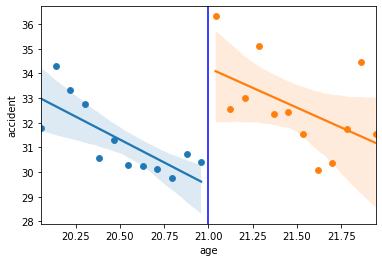

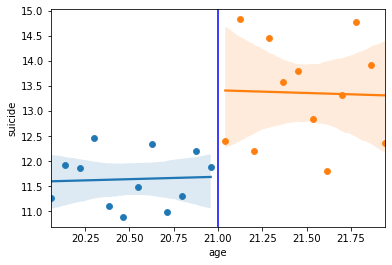

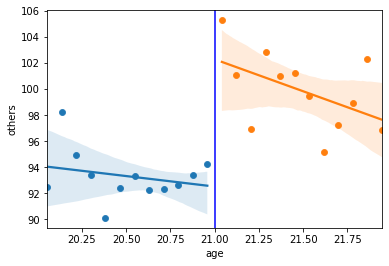

In [120]:
# plot graphs to show discontinuity, showing results for change in chances of death with all 3 features
sns.scatterplot(x = between_20_21['age'], y = between_20_21['accident'])
sns.regplot(x = between_20_21['age'], y = between_20_21['accident'])
sns.scatterplot(x = between_21_22['age'], y = between_21_22['accident'])
sns.regplot(x = between_21_22['age'], y = between_21_22['accident'])
plt.axvline(x = 21, color = 'b')
plt.show()

sns.scatterplot(x = between_20_21['age'], y = between_20_21['suicide'])
sns.regplot(x = between_20_21['age'], y = between_20_21['suicide'])
sns.scatterplot(x = between_21_22['age'], y = between_21_22['suicide'])
sns.regplot(x = between_21_22['age'], y = between_21_22['suicide'])
plt.axvline(x = 21, color = 'b')
plt.show()

sns.scatterplot(x = between_20_21['age'], y = between_20_21['others'])
sns.regplot(x = between_20_21['age'], y = between_20_21['others'])
sns.scatterplot(x = between_21_22['age'], y = between_21_22['others'])
sns.regplot(x = between_21_22['age'], y = between_21_22['others'])
plt.axvline(x = 21, color = 'b')
plt.show()

Based on the best fit trend lines, there is a noticeable discontinuity in all 3 cases (~4 for accident, ~2 for suicide, ~6 for others), but to check the robustness of this assumption, in a real-world dataset, we might want to check if the cutoff is a placebo. This involves shifting the cutoff from 21 and checking if discontinuities exist in those cases, too, so an assertion about raising / lowering the legal consumption of alcohol can be made if the discontinuities specifically exist at this cutoff.

Choosing a smaller bandwidth means including fewer points in the dataset, clustered around the cutoff. This has the benefit of reducing bias, but can also cause a loss in precision. Choosing the maximum bandwidth i.e. including all of the data, could lead to high bias, relying on extrapolation and assumptions in the functional form of the relationship between age and the dependent variable.

k-Nearest Neighbors (kNN) is a machine learning algorithm used for both classification and regression problems. In a kNN algorithm, data points are stored, and a prediction is made for a new data point by identifying the k nearest data points to the new data point and aggregating the results from those k data points. In a classification problem, if k = 3, the three nearest data points to the new data point are examined, and the most frequent class among those three data points is assigned as the predicted class for the new data point. In a regression problem, the mean or median value of the k nearest data points is used as the predicted output value for the new data point.

5. Use the iris.csv dataset for this question. How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7? Which of these is the optimal value of k? Which distance/similarity metric did you choose to use and why?

In [92]:
iris = pd.read_csv('iris.csv')

# one-hot encode "variety" column
iris['variety'] = iris.variety.replace({'Virginica': 0, 'Versicolor': 1, 'Setosa': 2})
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,2
1,4.9,3.0,1.4,0.2,2
2,4.7,3.2,1.3,0.2,2
3,4.6,3.1,1.5,0.2,2
4,5.0,3.6,1.4,0.2,2


In [93]:
X = iris[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']].to_numpy()
y = iris['variety'].to_numpy()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120,)
(30,)


In [97]:
k_values = [1, 3, 5, 7]
scores = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)

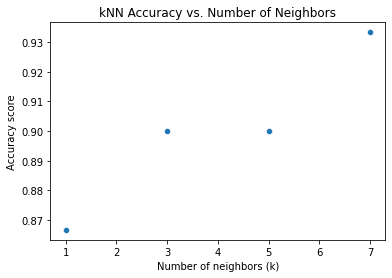

In [105]:
pairs = scores.items()
sns.scatterplot(x = [i[0] for i in pairs], y = [i[1] for i in pairs])
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy score')
plt.title('kNN Accuracy vs. Number of Neighbors')
plt.show()

As can be seen from the plot above, the optimal k with 0.93 classification accuracy is 7. As k increases, the classification boundary becomes smoother, preventing overfitting. In a real dataset, selecting k is a difficult task -- smaller k values are usually less computationally intensive but can be sensitive to noise. A simple approach in some cases -- without considering domain -- is selecting the number of neighbors to be $\sqrt{n}$, where $n$ is the sample size.

In [108]:
distance_metrics = ['manhattan', 'euclidean', 'chebyshev', 'minkowski']
k = 5 # keep k constant for easier comparison
scores = {}

for d in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors = k, metric = d)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[d] = metrics.accuracy_score(y_test, y_pred)
    
print(scores)

{'manhattan': 0.9333333333333333, 'euclidean': 0.9, 'chebyshev': 0.9, 'minkowski': 0.9}


Keeping k constant, and with all other factors the same, manipulating the distance metrics between the common choices above indicates that using Manhattan distance leads to the highest accuracy on the test set. Manhattan distance usually performs better when the data is multidimensional (e.g. 4 vs. 2, as in this case), or there is less of a relationship between individual features. 